In this pratcical part, you will see how to implement a panoramic image stitcher. This will build on the interest points and descriptors developed seen in 3DETech cours (SIFT keypoints). You'll begin with geometric filtering via knnMatch, then estimate pairwise rotations and chain these together to align the panorama. 


We need here OpenCV 3.4.2.

In [2]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 139kB/s 
     |████████████████████████████████| 14.5MB 324kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:


Start by download two images of a scene taken fron different points of view

In [ ]:
!wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/left.jpg
!wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/right.jpg

Load some required dependencies

In [ ]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [ ]:
rgb_l = cv2.cvtColor(cv2.imread("left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

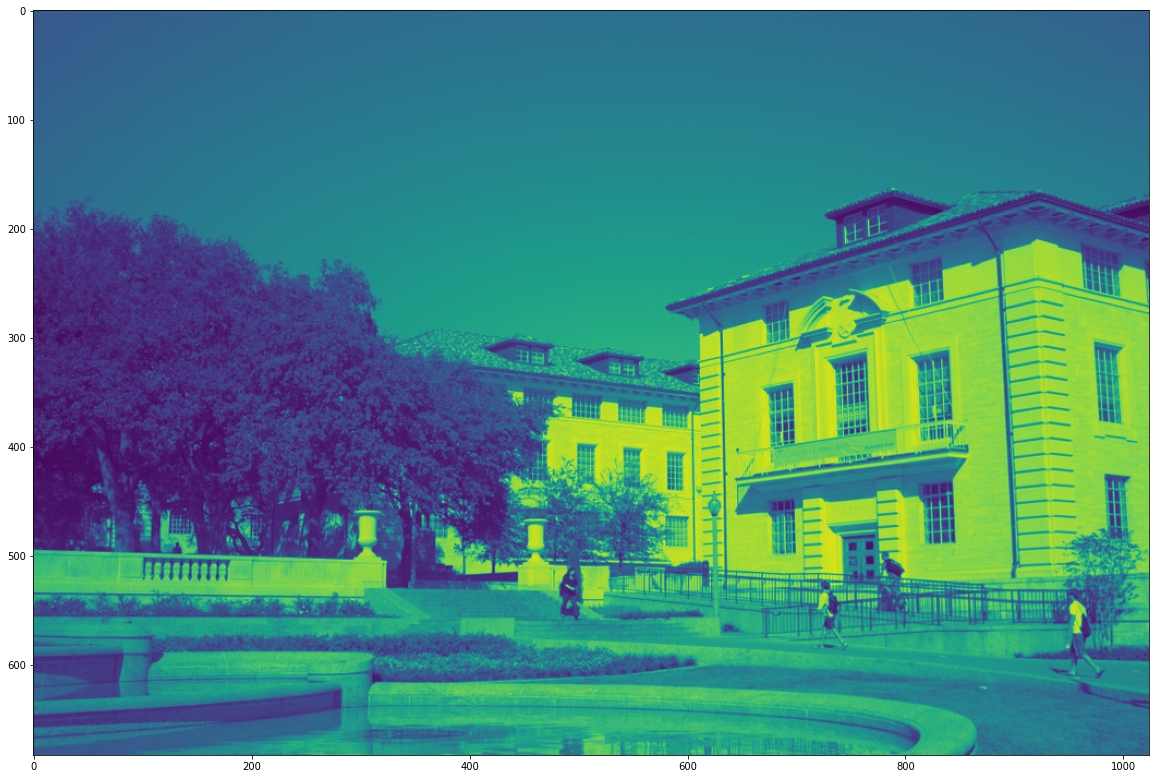

In [ ]:
figsize = (10, 10)
plt.figure(figsize=(20, 20))
plt.imshow(gray_r)

SIFT feature detection and description

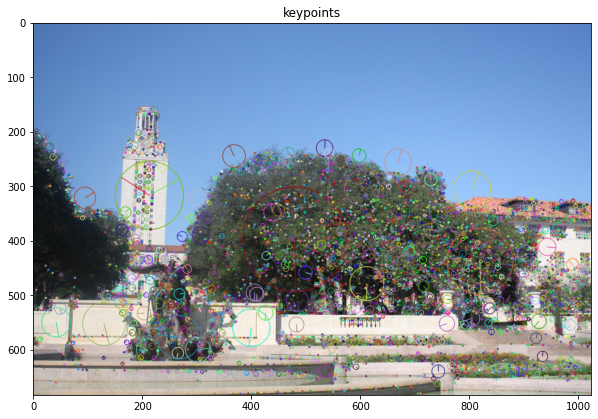

In [ ]:
# use orb if sift is not installed
feature_extractor = cv2.xfeatures2d.SIFT_create()
#feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#test = cv2.drawKeypoints(rgb_l, kp_l, None)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

After we get keypoints we need to find similar on both images. For this task we will use KNN matcher from OpenCV

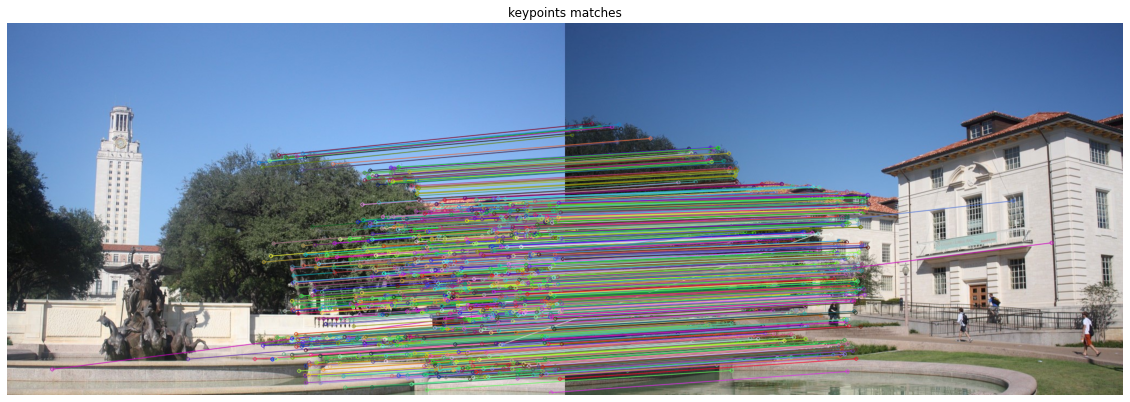

In [ ]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)
    
# store all the good matches as per Lowe's ratio test.
good_match = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_match.append(m)

# if less then 10 points matched -> not the same images or higly distorted 
MIN_MATCH_COUNT = 10
if len(good_match) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp_l[m.queryIdx].pt for m in good_match
                          ]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_r[m.trainIdx].pt for m in good_match
                          ]).reshape(-1, 1, 2)

    kp_l_matched=([ kp_l[m.queryIdx] for m in good_match ])
    kp_r_matched=([ kp_r[m.trainIdx] for m in good_match ])   

    matches = cv2.drawMatches(rgb_l,kp_l,rgb_r,kp_r, good_match,None, flags=2)
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.title("keypoints matches") 
    plt.imshow(matches),plt.show()  
    
    '''
    # Finds a perspective transformation between two planes. 
    # see https://ch.mathworks.com/help/images/examples/find-image-rotation-and-scale-using-automated-feature-matching.html for details
    ss = M[0, 1]
    sc = M[0, 0]
    scaleRecovered = math.sqrt(ss * ss + sc * sc)
    thetaRecovered = math.atan2(ss, sc) * 180 / math.pi
    print("Calculated scale difference: %.2f\nCalculated rotation difference: %.2f" % (scaleRecovered, thetaRecovered))
'''
        
else:
    print("Not  enough  matches are found   -   %d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None


Find homography between images (a perspective transformation between two planes. )



In [ ]:
H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
'''      
        good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match[:, 0]]).reshape(-1, 1, 2)
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match[:, 0]]).reshape(-1, 1, 2)
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)
'''
print(H)


[[ 7.68816088e-01  3.28823656e-02  4.47010895e+02]
 [-1.33599105e-01  9.09252297e-01  7.63224930e+01]
 [-2.06738262e-04 -3.70832264e-05  1.00000000e+00]]


**Image Warping Test**
The code below warps an image using a 3x3 transformation matrix. Experiment with the matrix H to test some of the different 2D transformations described in class, e.g., similarity, affine and projective transforms.

Recover the original image by transforming the distorted image.

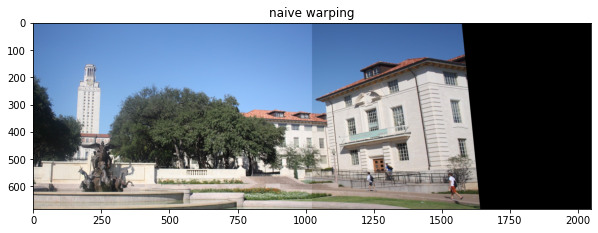

In [ ]:
rgb_r_warped = cv2.warpPerspective(rgb_r, H, (rgb_l.shape[1] + rgb_r.shape[1], rgb_l.shape[0]))
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()

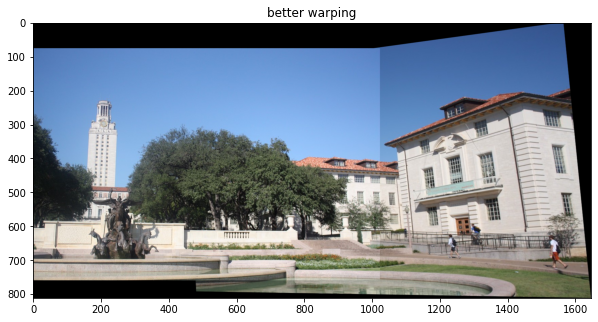

In [ ]:


def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result


result = warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("better warping")
plt.show()



To analyse the warping effect between the original image and retouched one, use the following images. 

In [ ]:
!wget -q -O test_1.jpg https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/test_1.jpg?raw=true
!wget -q -O test_1_edit.jpg https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/test_1_edit.jpg?raw=true

**Question 1:** Repeat the warping fonction to obtaine the following effect:

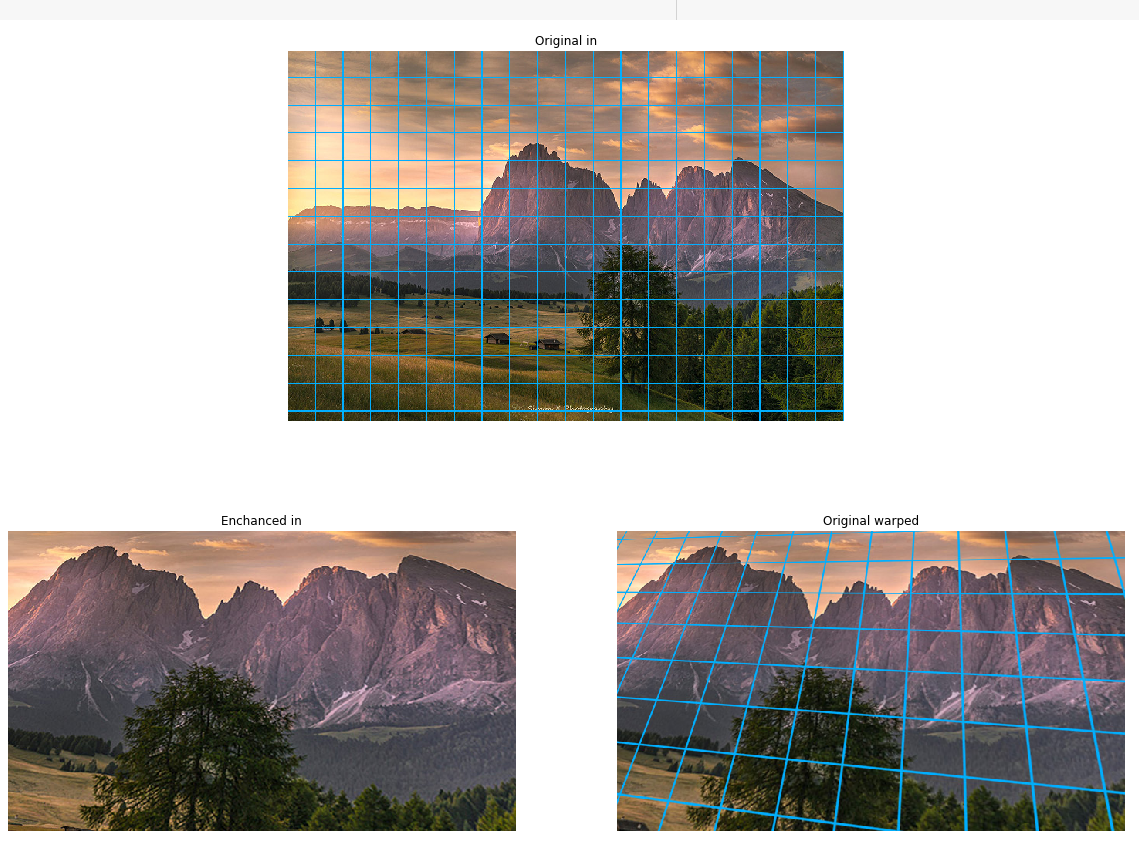

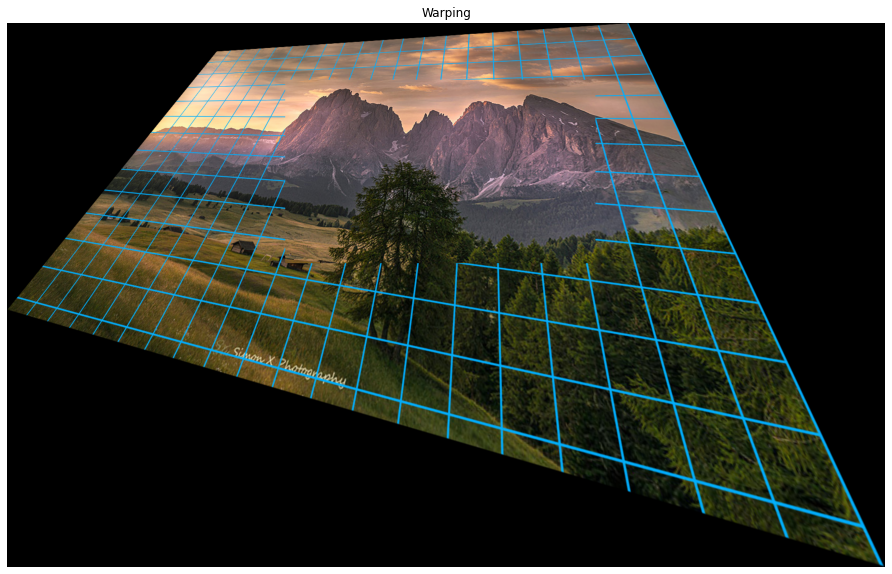

In [ ]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2

def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result

enhanced_img = cv2.cvtColor(cv2.imread("test_1_edit.jpg"), cv2.COLOR_BGR2RGB)
enhanced_grey = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
original_img = cv2.cvtColor(cv2.imread("test_1.jpg"), cv2.COLOR_BGR2RGB)
original_grey = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)


# use orb if sift is not installed
feature_extractor = cv2.xfeatures2d.SIFT_create()
#feature_extractor = cv2.SIFT_create()

# Find the keypoints and descriptors with chosen feature_extractor
kp_enhanced, desc_enhanced = feature_extractor.detectAndCompute(enhanced_grey, None)
kp_original, desc_original = feature_extractor.detectAndCompute(original_grey, None)

test = cv2.drawKeypoints(enhanced_img, kp_enhanced, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#test = cv2.drawKeypoints(rgb_l, kp_l, None)

# FEATURE MATCHING WITH KnnMatch
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_enhanced, desc_original, k=2)
    
# store all the good matches as per Lowe's ratio test.
good_match = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_match.append(m)

# if less then 10 points matched -> not the same images or higly distorted 
MIN_MATCH_COUNT = 10
if len(good_match) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp_enhanced[m.queryIdx].pt for m in good_match
                          ]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_original[m.trainIdx].pt for m in good_match
                          ]).reshape(-1, 1, 2)

    kp_enhanced_matched=([ kp_enhanced[m.queryIdx] for m in good_match ])
    kp_original_matched=([ kp_original[m.trainIdx] for m in good_match ])   

    matches = cv2.drawMatches(enhanced_img, kp_enhanced, original_img, kp_original, good_match, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    result = warpTwoImages(enhanced_img, original_img, H)

    plt.figure(figsize=(20,10))
    plt.axis('off')
    #plt.title("keypoints matches")
    #plt.imshow(matches),plt.show()  
    plt.title("Warping") 
    plt.imshow(result),plt.show() 
else:
    print("Not  enough  matches are found   -   %d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None






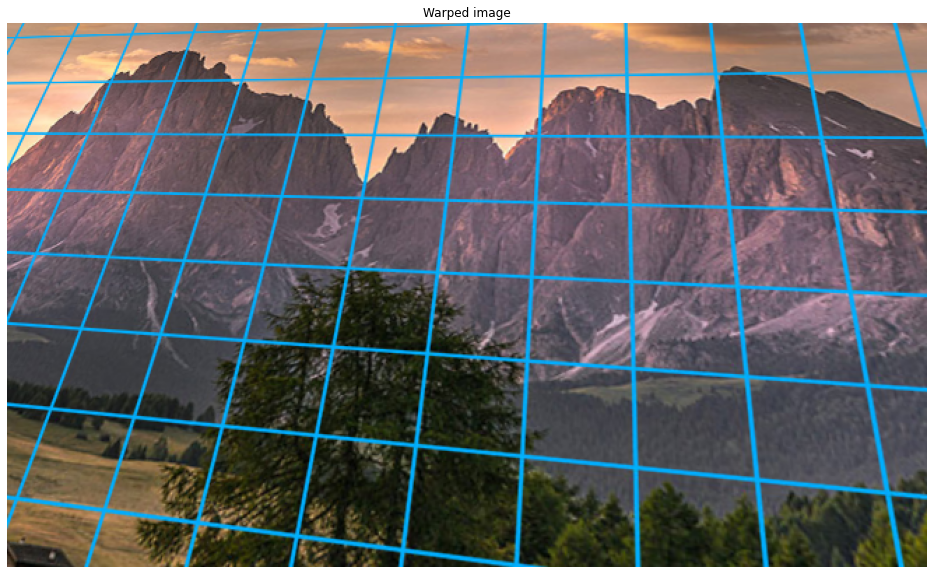

In [ ]:
enhanced_img = cv2.cvtColor(cv2.imread("test_1_edit.jpg"), cv2.COLOR_BGR2RGB)
enhanced_grey = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
original_img = cv2.cvtColor(cv2.imread("test_1.jpg"), cv2.COLOR_BGR2RGB)
original_grey = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)


# Use orb if sift is not installed
feature_extractor = cv2.xfeatures2d.SIFT_create()
#feature_extractor = cv2.SIFT_create()

# Find the keypoints and descriptors with chosen feature_extractor
kp_enhanced, desc_enhanced = feature_extractor.detectAndCompute(enhanced_grey, None)
kp_original, desc_original = feature_extractor.detectAndCompute(original_grey, None)

test = cv2.drawKeypoints(enhanced_img, kp_enhanced, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#test = cv2.drawKeypoints(rgb_l, kp_l, None)

# FEATURE MATCHING WITH KnnMatch
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_enhanced, desc_original, k=2)
    
# store all the good matches as per Lowe's ratio test.
good_match = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_match.append(m)

# if less then 10 points matched -> not the same images or higly distorted 
MIN_MATCH_COUNT = 10
if len(good_match) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp_enhanced[m.queryIdx].pt for m in good_match
                          ]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_original[m.trainIdx].pt for m in good_match
                          ]).reshape(-1, 1, 2)

    kp_enhanced_matched=([ kp_enhanced[m.queryIdx] for m in good_match ])
    kp_original_matched=([ kp_original[m.trainIdx] for m in good_match ])   

    matches = cv2.drawMatches(enhanced_img, kp_enhanced, original_img, kp_original, good_match, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    # Find Homography Matrix
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp
    #original_warped = cv2.warpPerspective(original_img, H, (enhanced_img.shape[1] + original_img.shape[1], enhanced_img.shape[0]))
    #original_warped[0:enhanced_img.shape[0], 0:enhanced_img.shape[1]] = enhanced_img
    original_warped = cv2.warpPerspective(original_img, H, (enhanced_img.shape[1], enhanced_img.shape[0]))
    result = original_warped

    plt.figure(figsize=(20,10))
    plt.axis('off') 
    plt.title("Warped image") 
    plt.imshow(result),plt.show() 
else:
    print("Not  enough  matches are found   -   %d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None

**Question 2**: extend this program to several images taken from different points of view in order to obtain more complet panoramic image.

In [ ]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2

def makePanorama(imageList):
  tmpImg = cv2.imread(imageList[0])
  current_warped = np.zeros((tmpImg.shape[0],tmpImg.shape[1],3), np.uint8)

  for i, img in enumerate(imageList):
    if i == 0: continue
    print(str(i))

    prev_img = cv2.cvtColor(cv2.imread(imageList[i-1]), cv2.COLOR_BGR2RGB)
    prev_grey = cv2.cvtColor(prev_img, cv2.COLOR_RGB2GRAY)
    current_img = cv2.cvtColor(cv2.imread(imageList[i]), cv2.COLOR_BGR2RGB)
    current_grey = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)

    # Feature extractor / Detector
    # Use orb if sift is not installed
    feature_extractor = cv2.xfeatures2d.SIFT_create()
    #feature_extractor = cv2.SIFT_create()

    # Find the keypoints and descriptors with chosen feature_extractor
    kp_prev, desc_prev = feature_extractor.detectAndCompute(prev_grey, None)
    kp_current, desc_current = feature_extractor.detectAndCompute(current_grey, None)

    test = cv2.drawKeypoints(prev_img, kp_prev, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # FEATURE MATCHING WITH KnnMatch
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc_prev, desc_current, k=2)
        
    # store all the good matches as per Lowe's ratio test.
    good_match = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_match.append(m)

    # if less then 10 points matched -> not the same images or higly distorted 
    MIN_MATCH_COUNT = 10
    if len(good_match) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp_prev[m.queryIdx].pt for m in good_match
                              ]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_current[m.trainIdx].pt for m in good_match
                              ]).reshape(-1, 1, 2)

        kp_prev_matched=([ kp_prev[m.queryIdx] for m in good_match ])
        kp_current_matched=([ kp_current[m.trainIdx] for m in good_match ])   

        matches = cv2.drawMatches(prev_img, kp_prev, current_img, kp_current, good_match, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

        # Find Homography Matrix
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        # Warp
        current_warped = cv2.warpPerspective(current_img, H, (prev_img.shape[1] + current_warped.shape[1], current_warped.shape[0]))
        if i-1 == 0:
          current_warped[0:prev_img.shape[0], 0:prev_img.shape[1]] = prev_img

    else:
        print("Not  enough  matches are found   -   %d/%d" % (len(good), MIN_MATCH_COUNT))
        matchesMask = None

  plt.figure(figsize=(20,10))
  plt.axis('off') 
  plt.title("Warped image") 
  plt.imshow(current_warped),plt.show()

list = []
i = 1
while i < 3:
  list.append("panorama" + str(i) + ".jpg")
  i+=1

makePanorama(list)

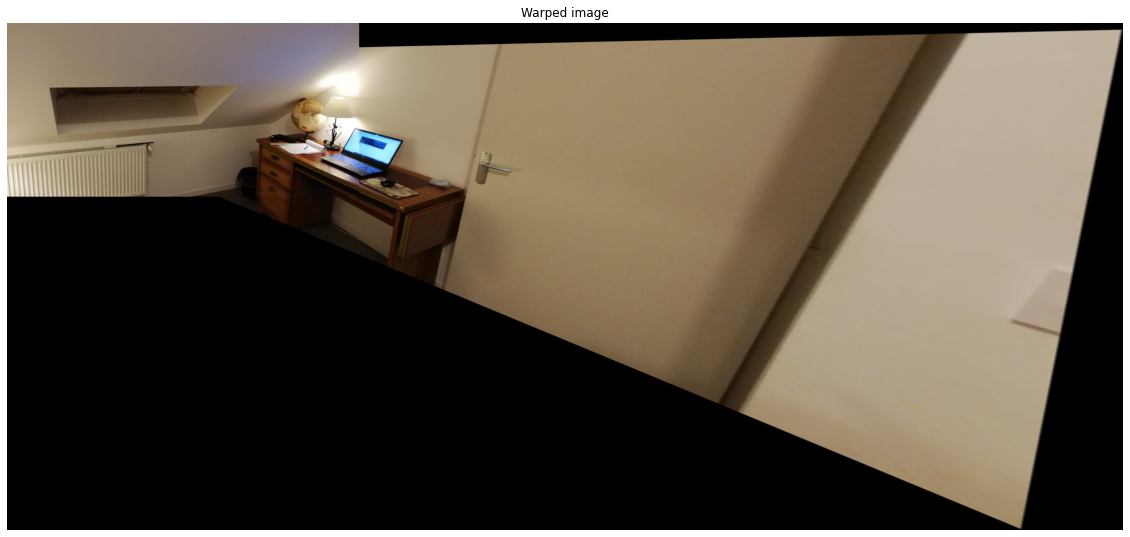

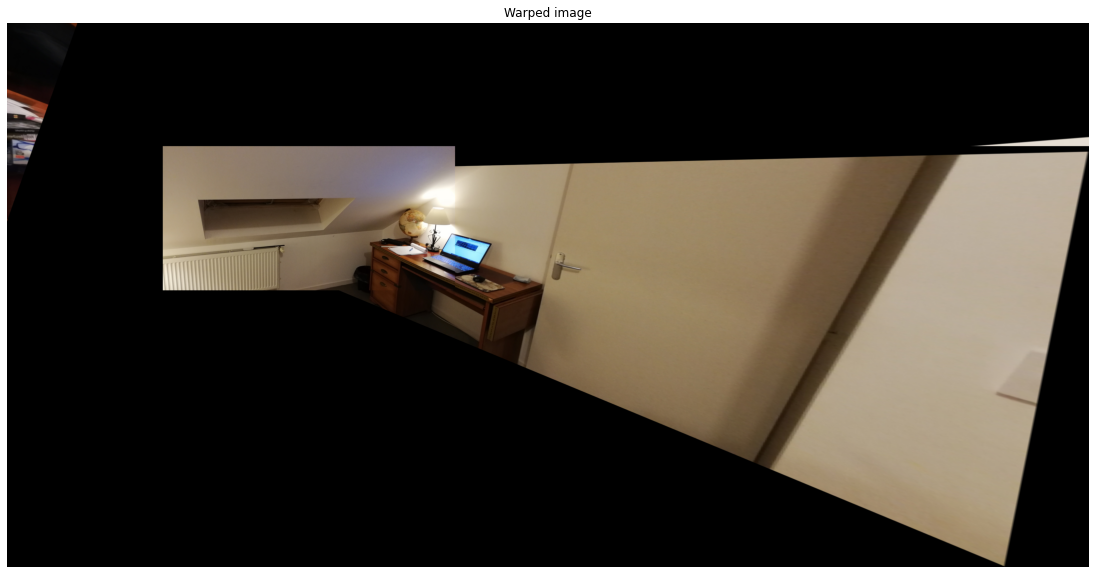

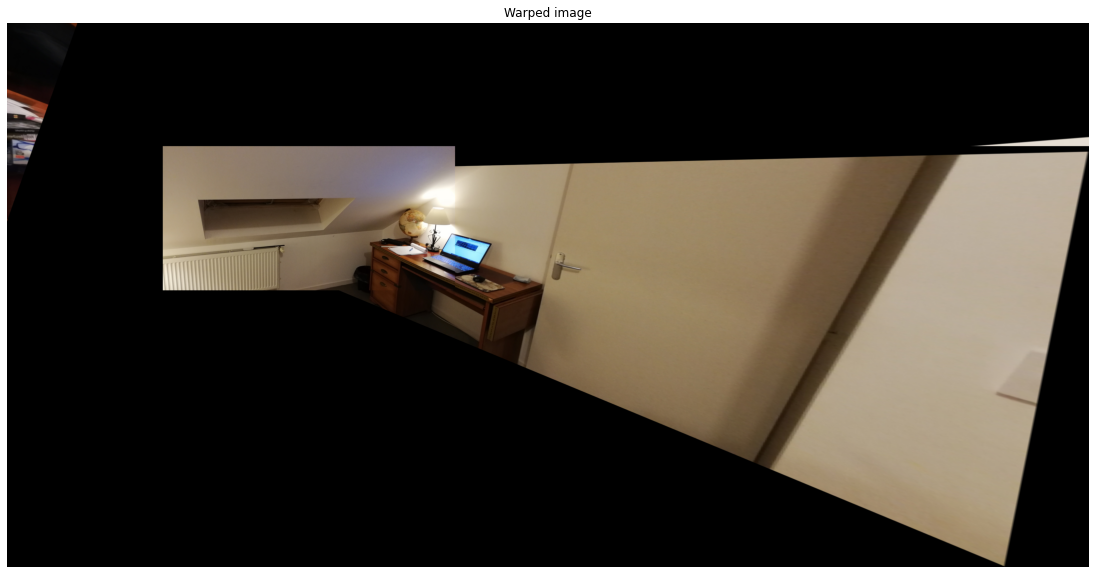

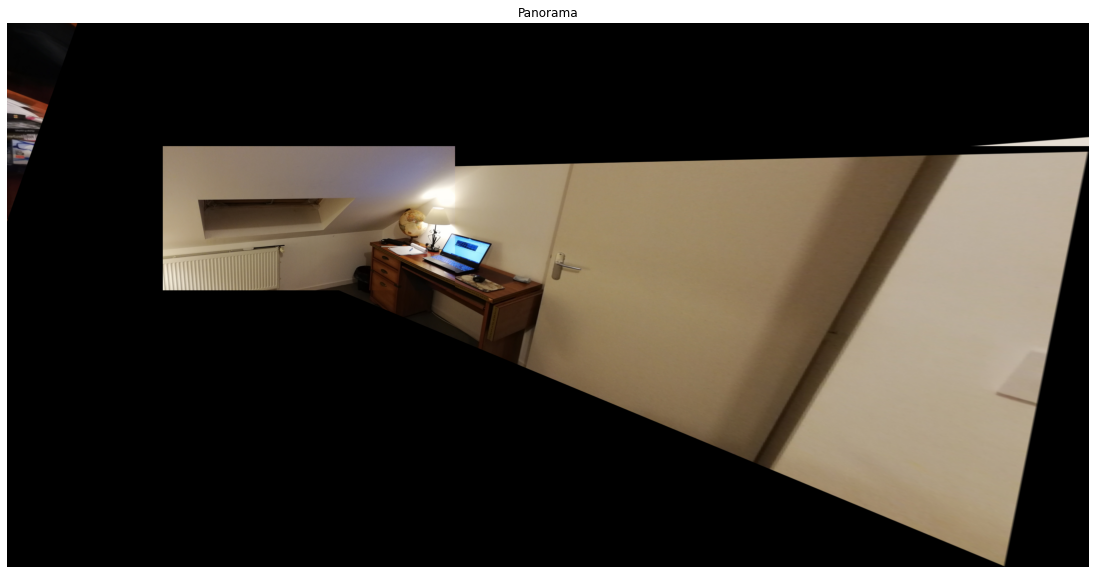

In [2]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2

def warpTwoImages(img1, img2, H):
  '''warp img2 to img1 with homograph H
  from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
  '''
  h1, w1 = img1.shape[:2]
  h2, w2 = img2.shape[:2]
  pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
  pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
  pts2_ = cv2.perspectiveTransform(pts2, H)
  pts = np.concatenate((pts1, pts2_), axis=0)
  [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
  [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
  t = [-xmin, -ymin]
  Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

  result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
  result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
  return result

def stitch(image1, image2):
  img1 = image1
  img1_grey = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
  img2 = image2
  img2_grey = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

  # Feature extractor / Detector
  # Use orb if sift is not installed
  feature_extractor = cv2.xfeatures2d.SIFT_create()
  #feature_extractor = cv2.SIFT_create()

  # Find the keypoints and descriptors with chosen feature_extractor
  kp_img1, desc_img1 = feature_extractor.detectAndCompute(img1_grey, None)
  kp_img2, desc_img2 = feature_extractor.detectAndCompute(img2_grey, None)

  test = cv2.drawKeypoints(img1, kp_img1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  # FEATURE MATCHING WITH KnnMatch
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc_img1, desc_img2, k=2)
      
  # store all the good matches as per Lowe's ratio test.
  good_match = []
  for m, n in matches:
      if m.distance < 0.7 * n.distance:
          good_match.append(m)
  matches.clear()
  # if less then 10 points matched -> not the same images or higly distorted 
  MIN_MATCH_COUNT = 10
  if len(good_match) > MIN_MATCH_COUNT:
      src_pts = np.float32([kp_img1[m.queryIdx].pt for m in good_match
                            ]).reshape(-1, 1, 2)
      dst_pts = np.float32([kp_img2[m.trainIdx].pt for m in good_match
                            ]).reshape(-1, 1, 2)

      kp_img1_matched=([ kp_img1[m.queryIdx] for m in good_match ])
      kp_img2_matched=([ kp_img2[m.trainIdx] for m in good_match ])   

      #cv2.drawMatches(img1, kp_img1, img2, kp_img2, good_match, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

      # Find Homography Matrix
      H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

      # Warp
      warped = warpTwoImages(img1, img2, H)
      #warped = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
      #warped[0:img1.shape[0], 0:img1.shape[1]] = img1


      plt.figure(figsize=(20,10))
      plt.axis('off') 
      plt.title("Warped image") 
      plt.imshow(warped)

      return warped
  else:
      print("Not  enough  matches are found   -   %d/%d" % (len(good_match), MIN_MATCH_COUNT))
      matchesMask = None

  return np.zeros((img1.shape[0], img1.shape[1], 3), dtype=np.uint8) #Image vide

# Load images
pano1 = cv2.imread('old/panorama1_lowdef.jpg')
pano2 = cv2.imread('old/panorama2_lowdef.jpg')
pano3 = cv2.imread('old/panorama3_lowdef.jpg')
pano4 = cv2.imread('old/panorama4_lowdef.jpg')

# Colors
pano1 = cv2.cvtColor(pano1, cv2.COLOR_BGR2RGB)
pano2 = cv2.cvtColor(pano2, cv2.COLOR_BGR2RGB)
pano3 = cv2.cvtColor(pano3, cv2.COLOR_BGR2RGB)
pano4 = cv2.cvtColor(pano4, cv2.COLOR_BGR2RGB)

# Stitch
result = stitch(pano1, pano2)
result = stitch(result, pano3)
result = stitch(result, pano4)

plt.figure(figsize=(20,10))
plt.axis('off') 
plt.title("Panorama") 
plt.imshow(result)

plt.show()